# Imports

In [128]:
import math as math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest
from sklearn.preprocessing import StandardScaler, Normalizer, KBinsDiscretizer, FunctionTransformer, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Data loading

In [129]:
data_cols = ["RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe"]
class_col = "class"
data_cols_names = {
    "RI": "współczynnik załamania",
    "Na": "sód",
    "Mg": "magnez",
    "Al": "glin",
    "Si": "krzem",
    "K": "potas",
    "Ca": "wapń",
    "Ba": "bar",
    "Fe": "żelazo"
    }
col_names = ["id", *data_cols, class_col]

file_path = "./glass.data"
dataset = pd.read_csv(file_path, names=col_names)

# Data exploration

In [130]:
dataset.shape

(214, 11)

In [131]:
dataset.head(10)

,id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,class
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.00,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.00,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.00,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.00,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.00,1
5,6,1.51596,12.79,3.61,1.62,72.97,0.64,8.07,0.0,0.26,1
6,7,1.51743,13.30,3.60,1.14,73.09,0.58,8.17,0.0,0.00,1
7,8,1.51756,13.15,3.61,1.05,73.24,0.57,8.24,0.0,0.00,1
8,9,1.51918,14.04,3.58,1.37,72.08,0.56,8.30,0.0,0.00,1
9,10,1.51755,13.00,3.60,1.36,72.99,0.57,8.40,0.0,0.11,1


In [132]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      214 non-null    int64  
 1   RI      214 non-null    float64
 2   Na      214 non-null    float64
 3   Mg      214 non-null    float64
 4   Al      214 non-null    float64
 5   Si      214 non-null    float64
 6   K       214 non-null    float64
 7   Ca      214 non-null    float64
 8   Ba      214 non-null    float64
 9   Fe      214 non-null    float64
 10  class   214 non-null    int64  
dtypes: float64(9), int64(2)
memory usage: 18.5 KB


In [133]:
dataset.loc[:, data_cols].describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000


In [134]:
dataset.isnull().sum()

id       0
RI       0
Na       0
Mg       0
Al       0
Si       0
K        0
Ca       0
Ba       0
Fe       0
class    0
dtype: int64

In [135]:
dataset[class_col].value_counts().sort_index()

class
1    70
2    76
3    17
5    13
6     9
7    29
Name: count, dtype: int64

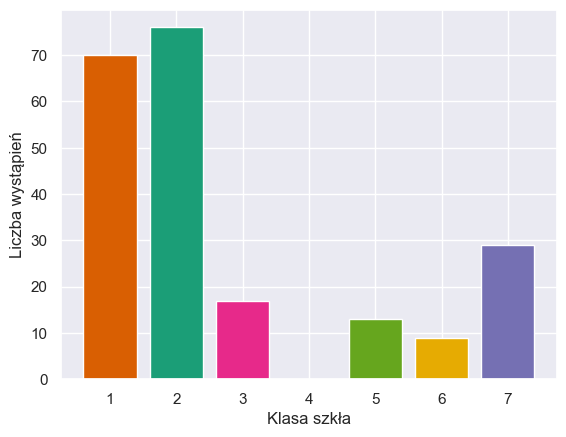

In [136]:
color_palette = matplotlib.colormaps["Dark2"]

class_values = dataset[class_col].value_counts()
plt.bar(class_values.index, class_values.values, color=color_palette(range(len(class_values))))
plt.ylabel('Liczba wystąpień')
plt.xlabel('Klasa szkła')
plt.show()

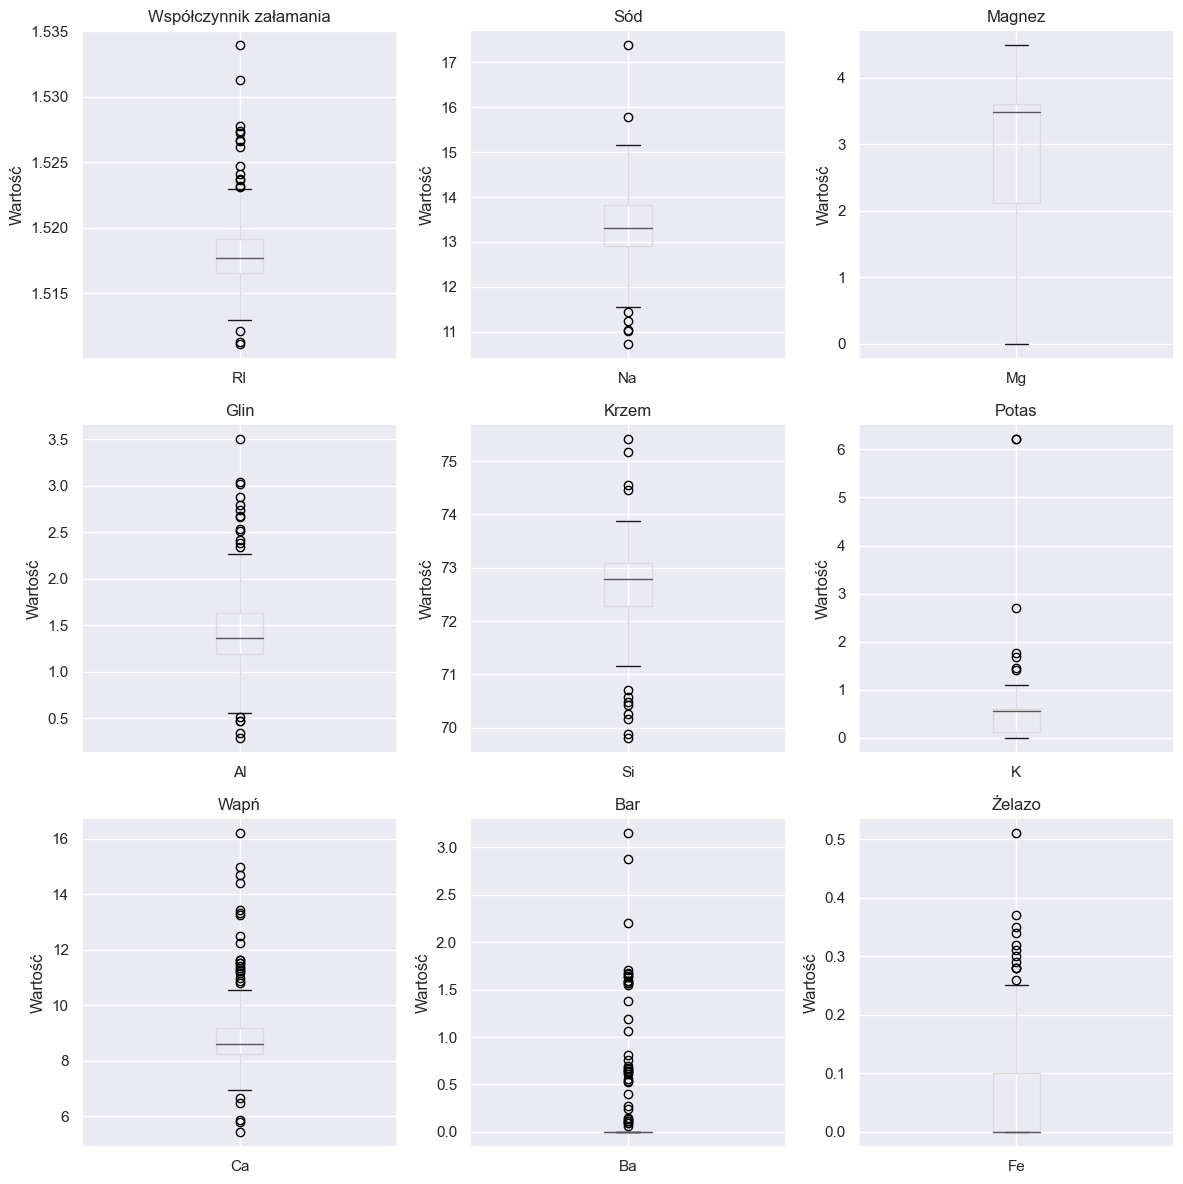

In [137]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

for i, column in enumerate(data_cols):
    ax = axes[i // 3, i % 3]
    dataset.boxplot(column=[column], ax=ax)
    ax.set_title(f'{data_cols_names[column].capitalize()}')
    ax.set_ylabel('Wartość')

plt.tight_layout()
plt.show()

Glass class: 1


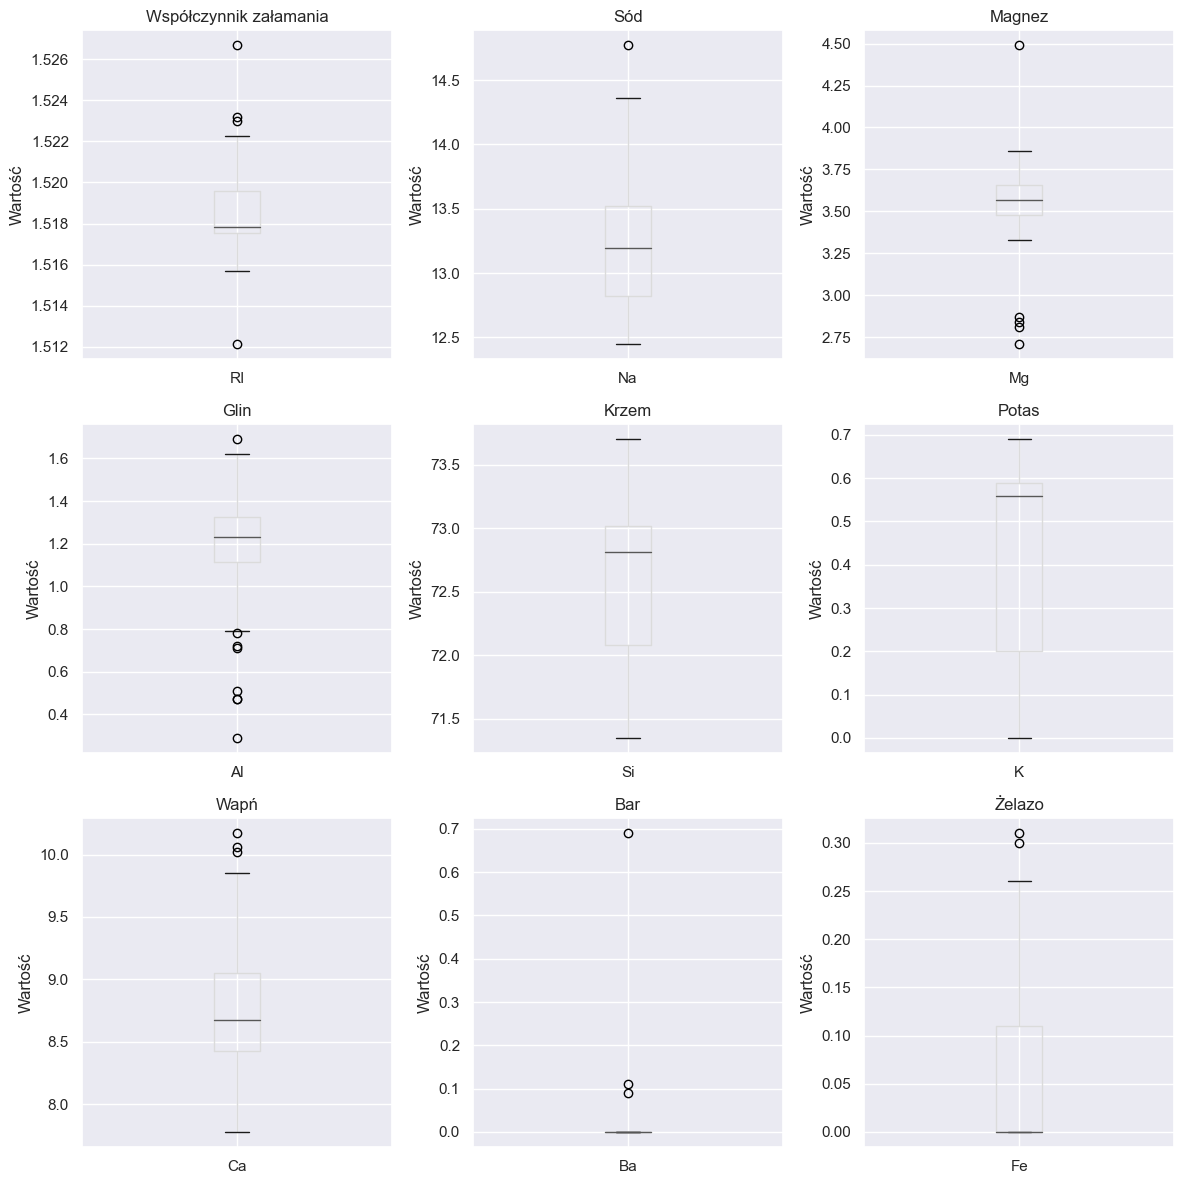

Glass class: 2


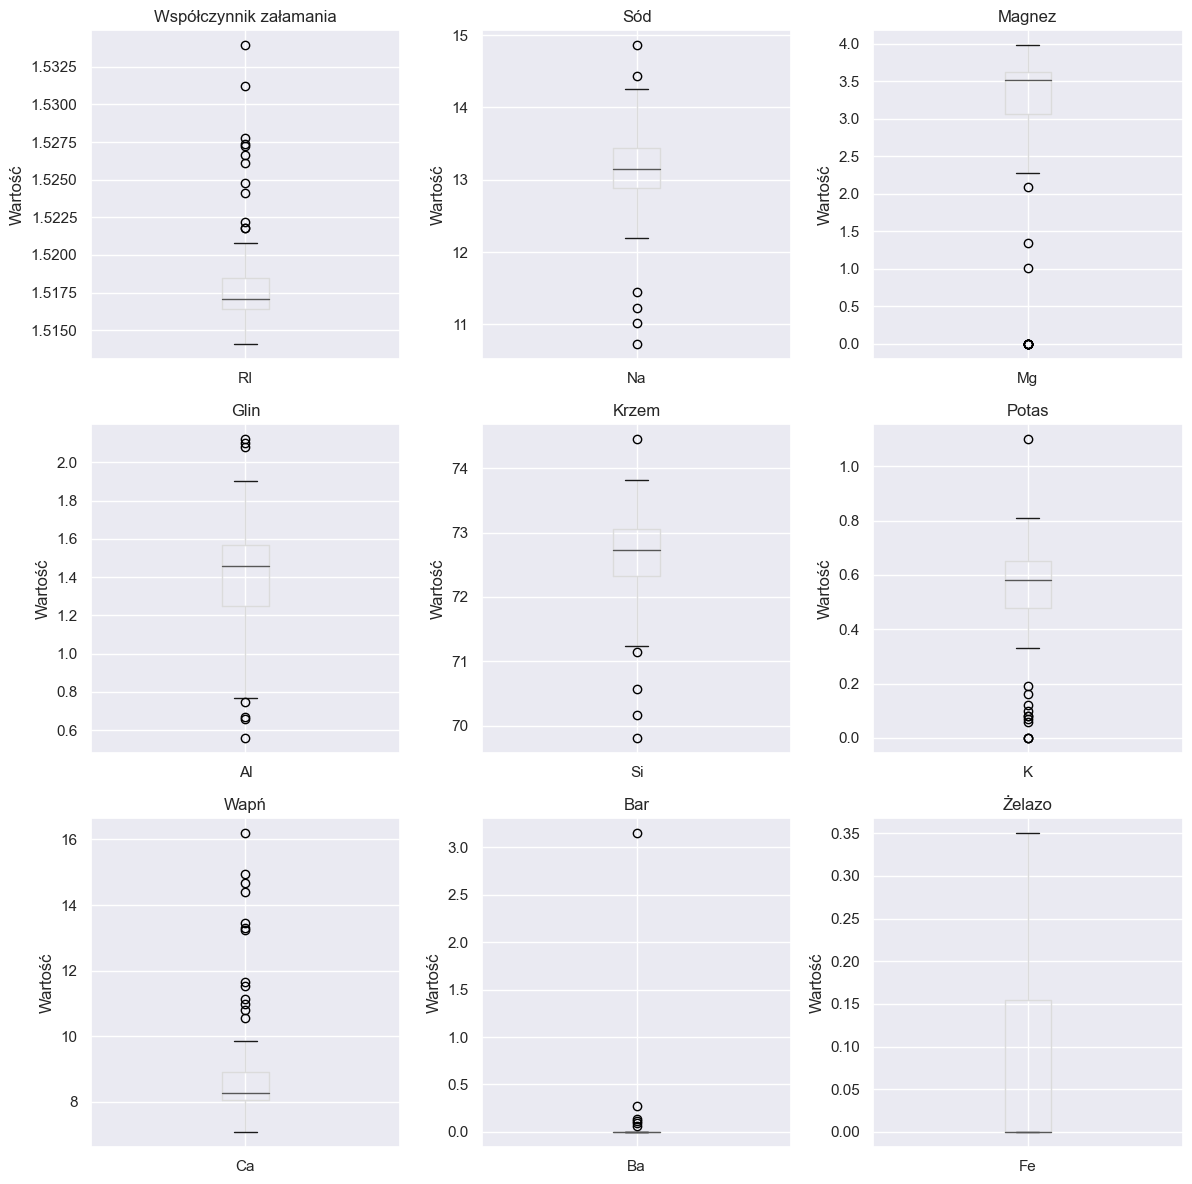

Glass class: 3


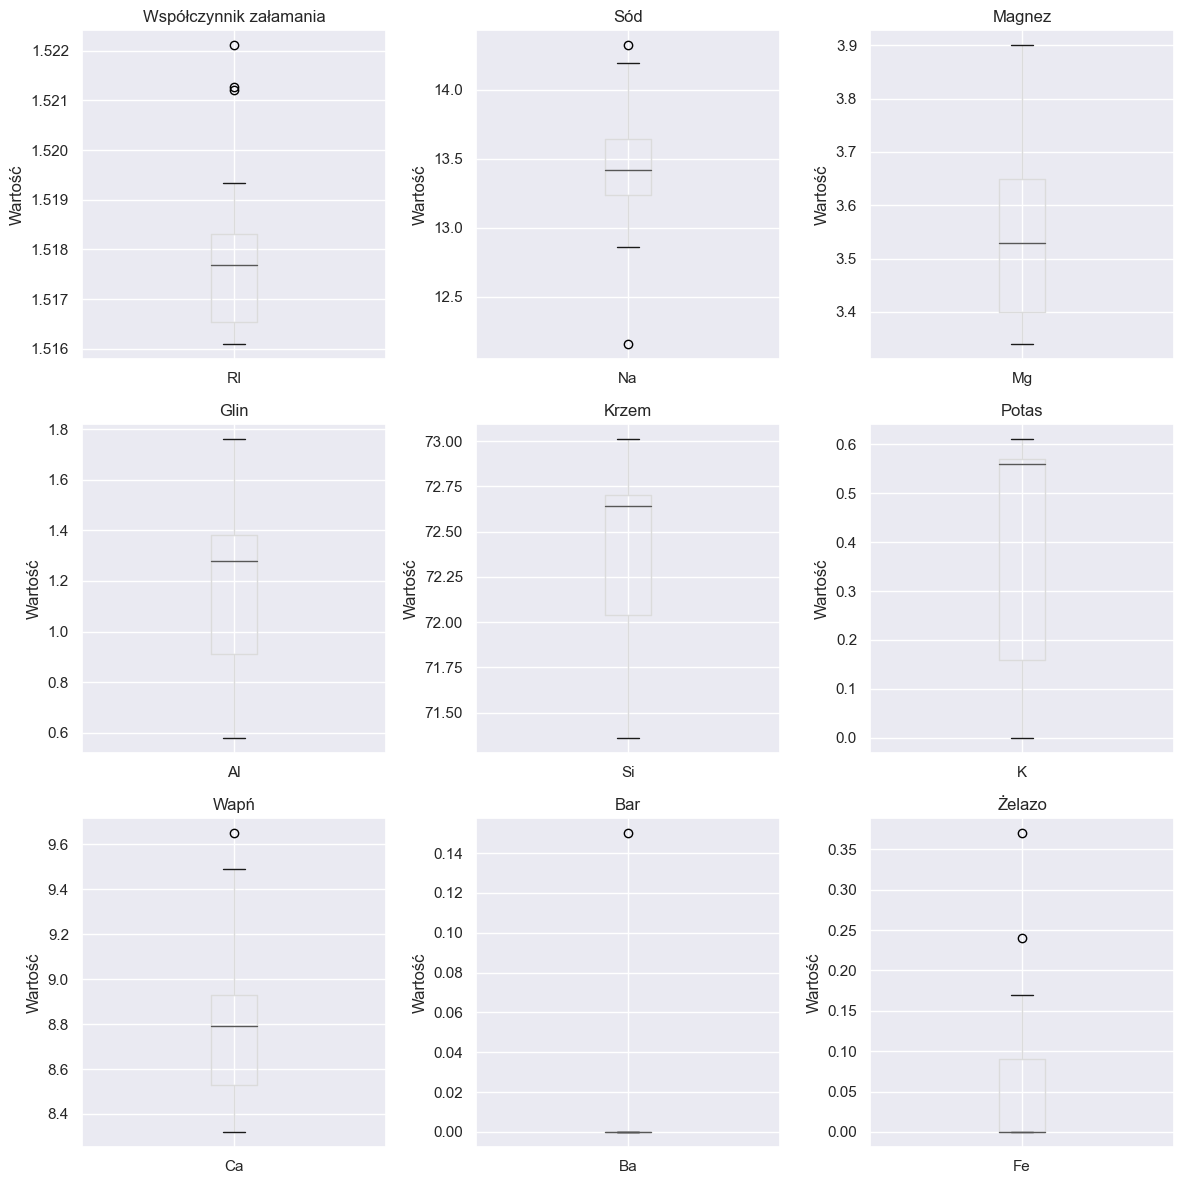

Glass class: 4


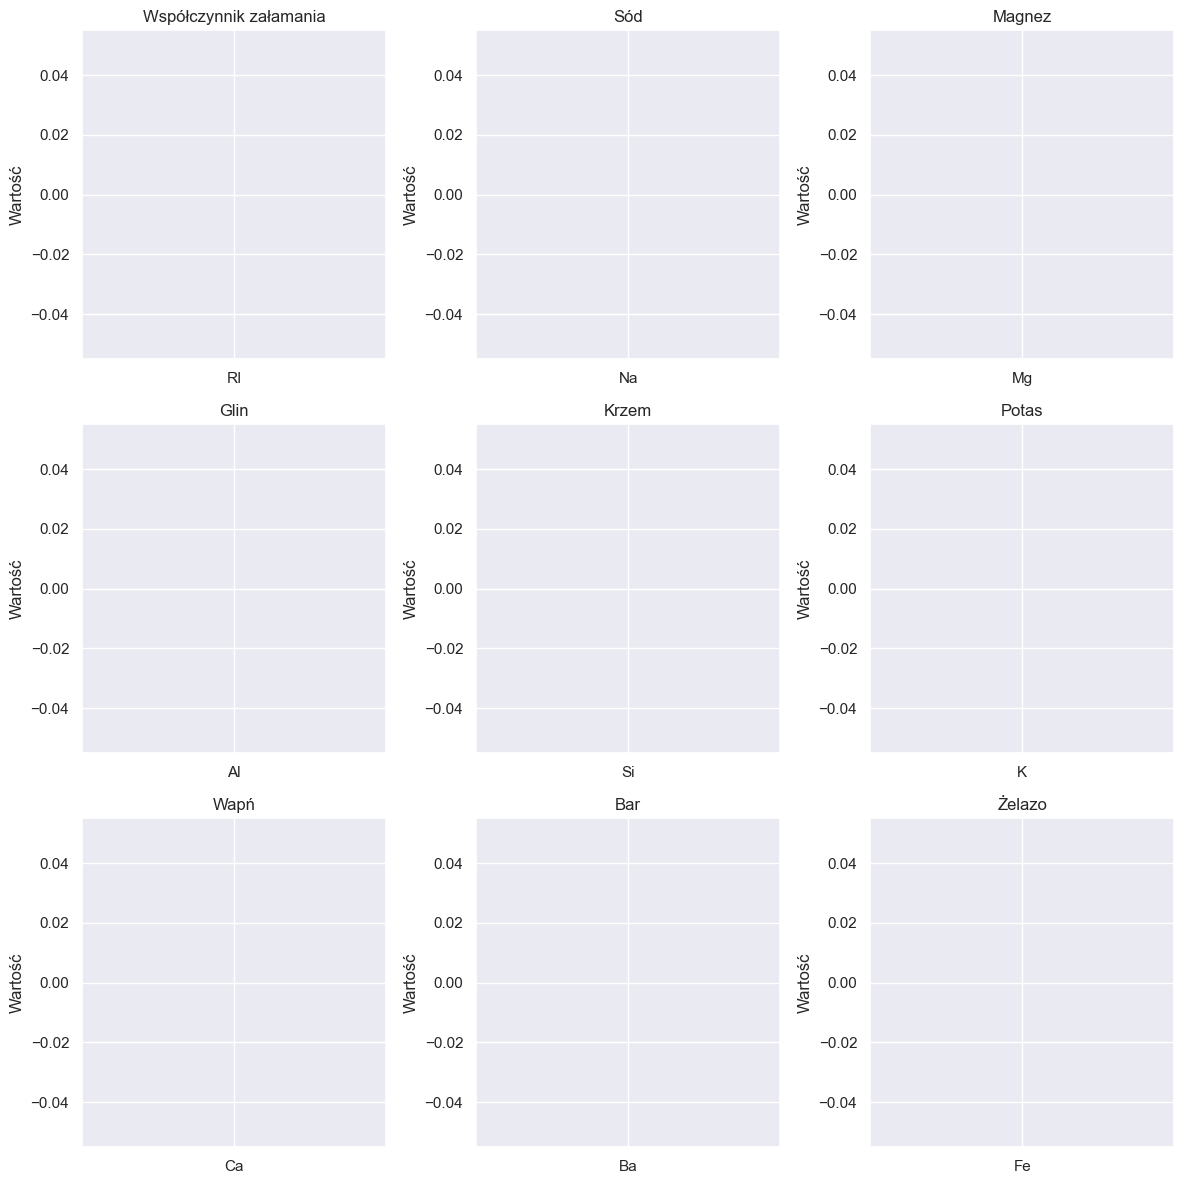

Glass class: 5


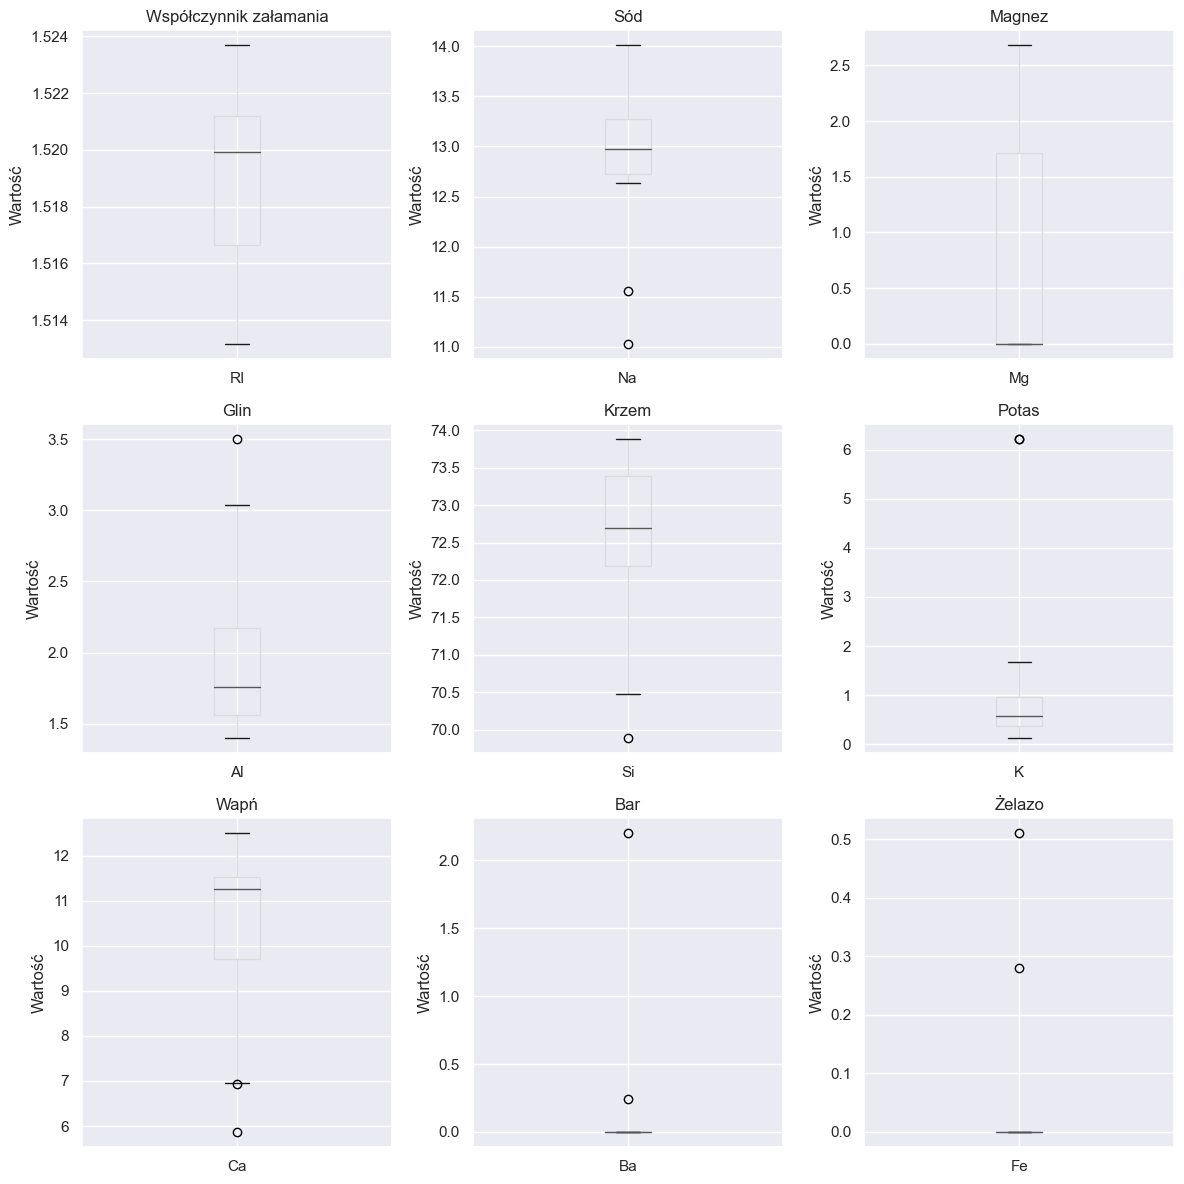

Glass class: 6


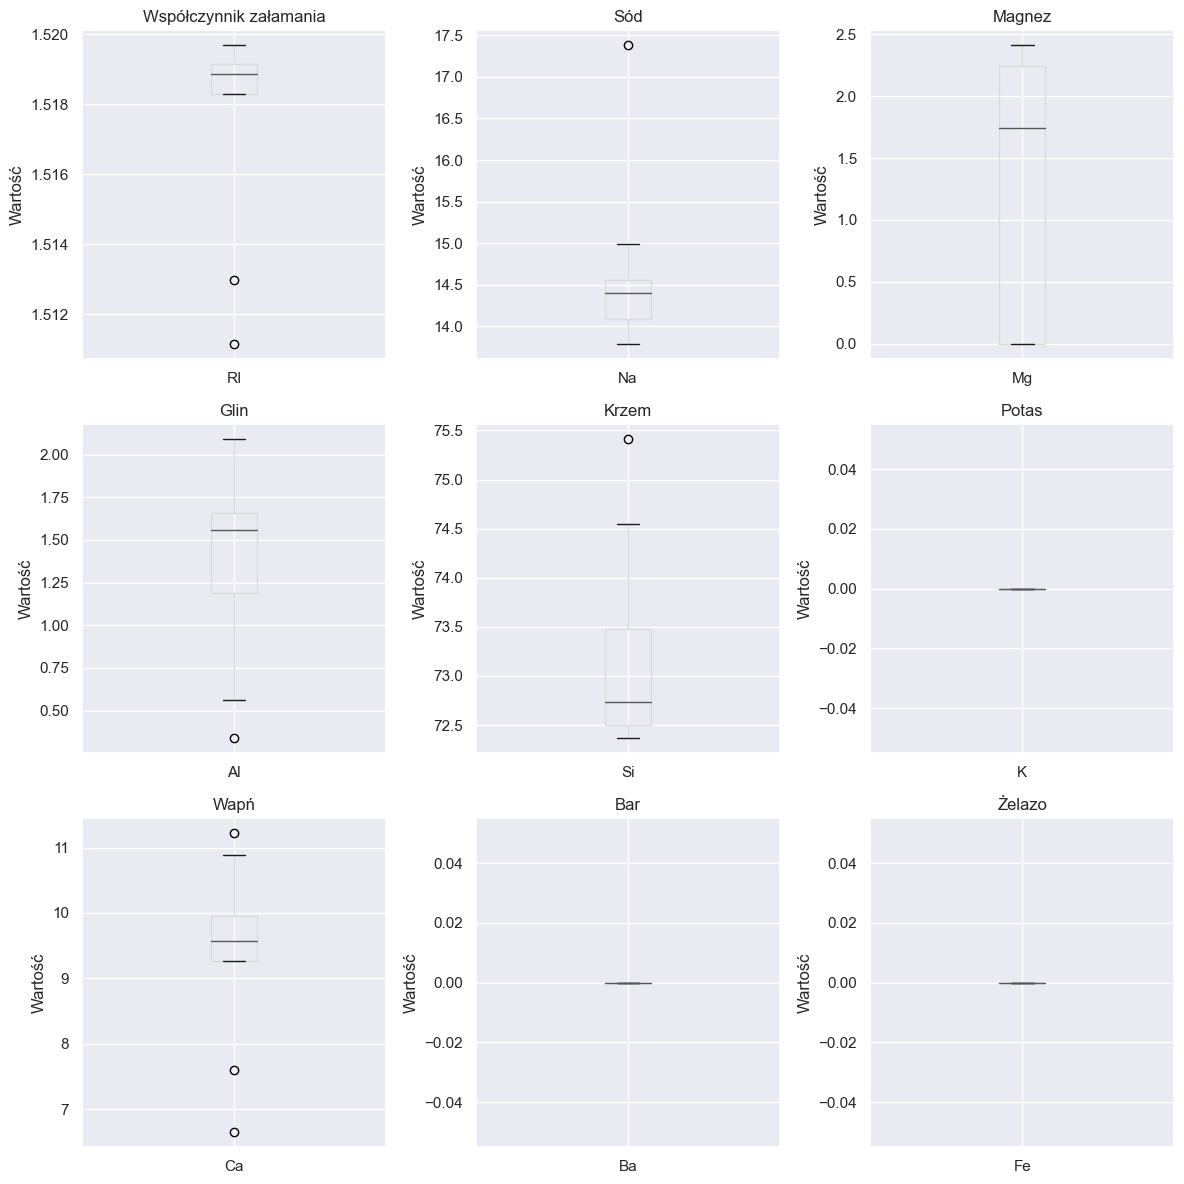

Glass class: 7


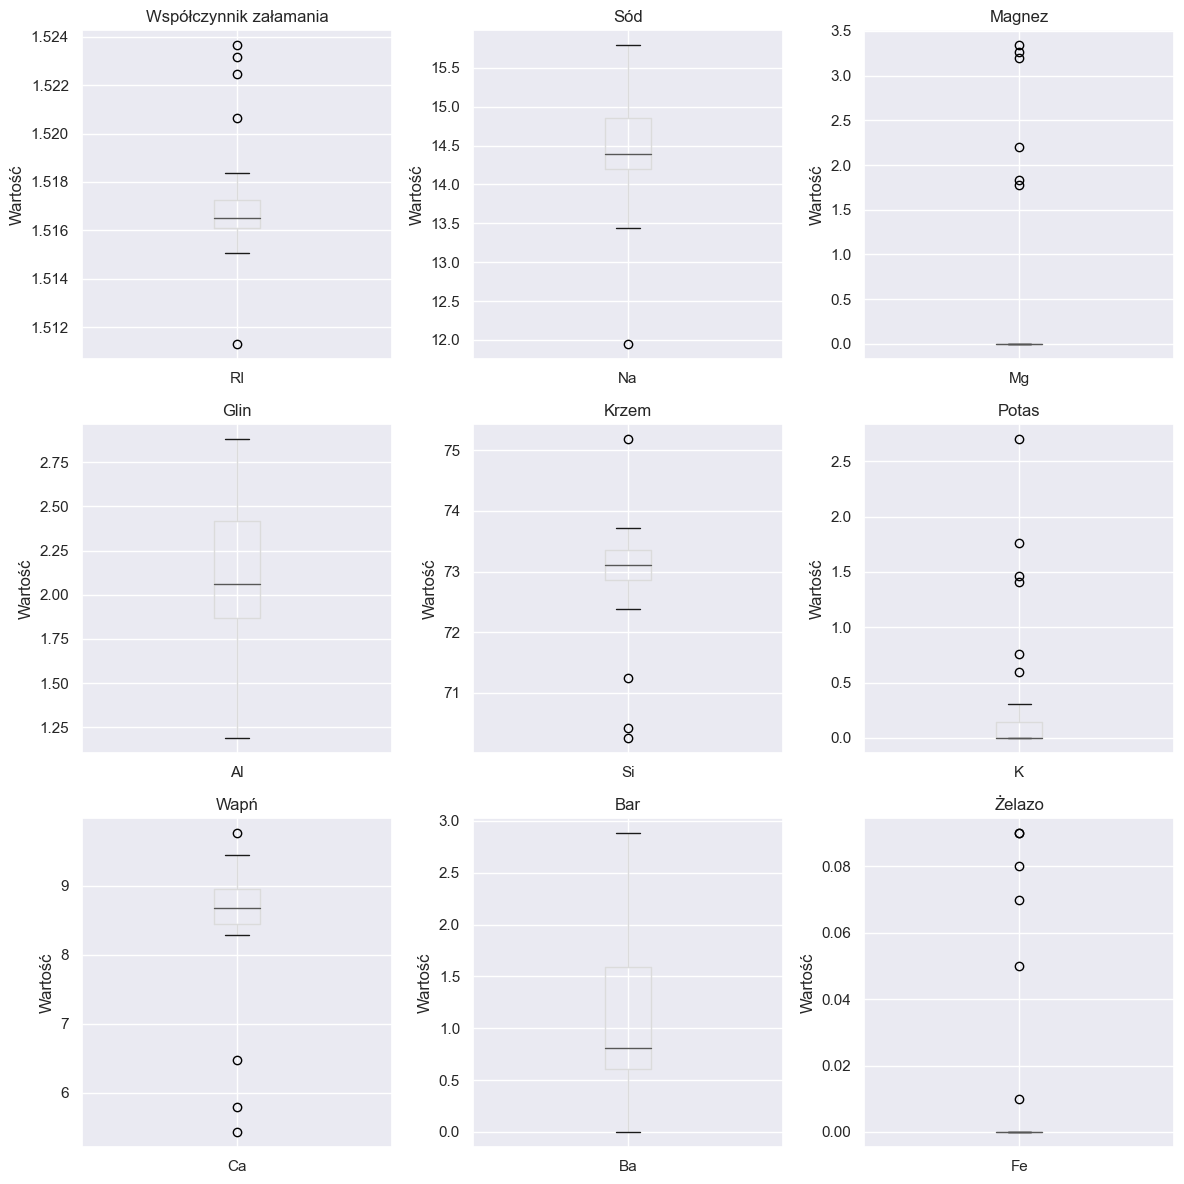

In [138]:
for i in range(1, 8):
    print(f"Glass class: {i}")
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))

    for j, column in enumerate(data_cols):
        ax = axes[j // 3, j % 3]
        dataset[dataset[class_col] == i].boxplot(column=[column], ax=ax)
        ax.set_title(f'{data_cols_names[column].capitalize()}')
        ax.set_ylabel('Wartość')

    plt.tight_layout()
    plt.show()

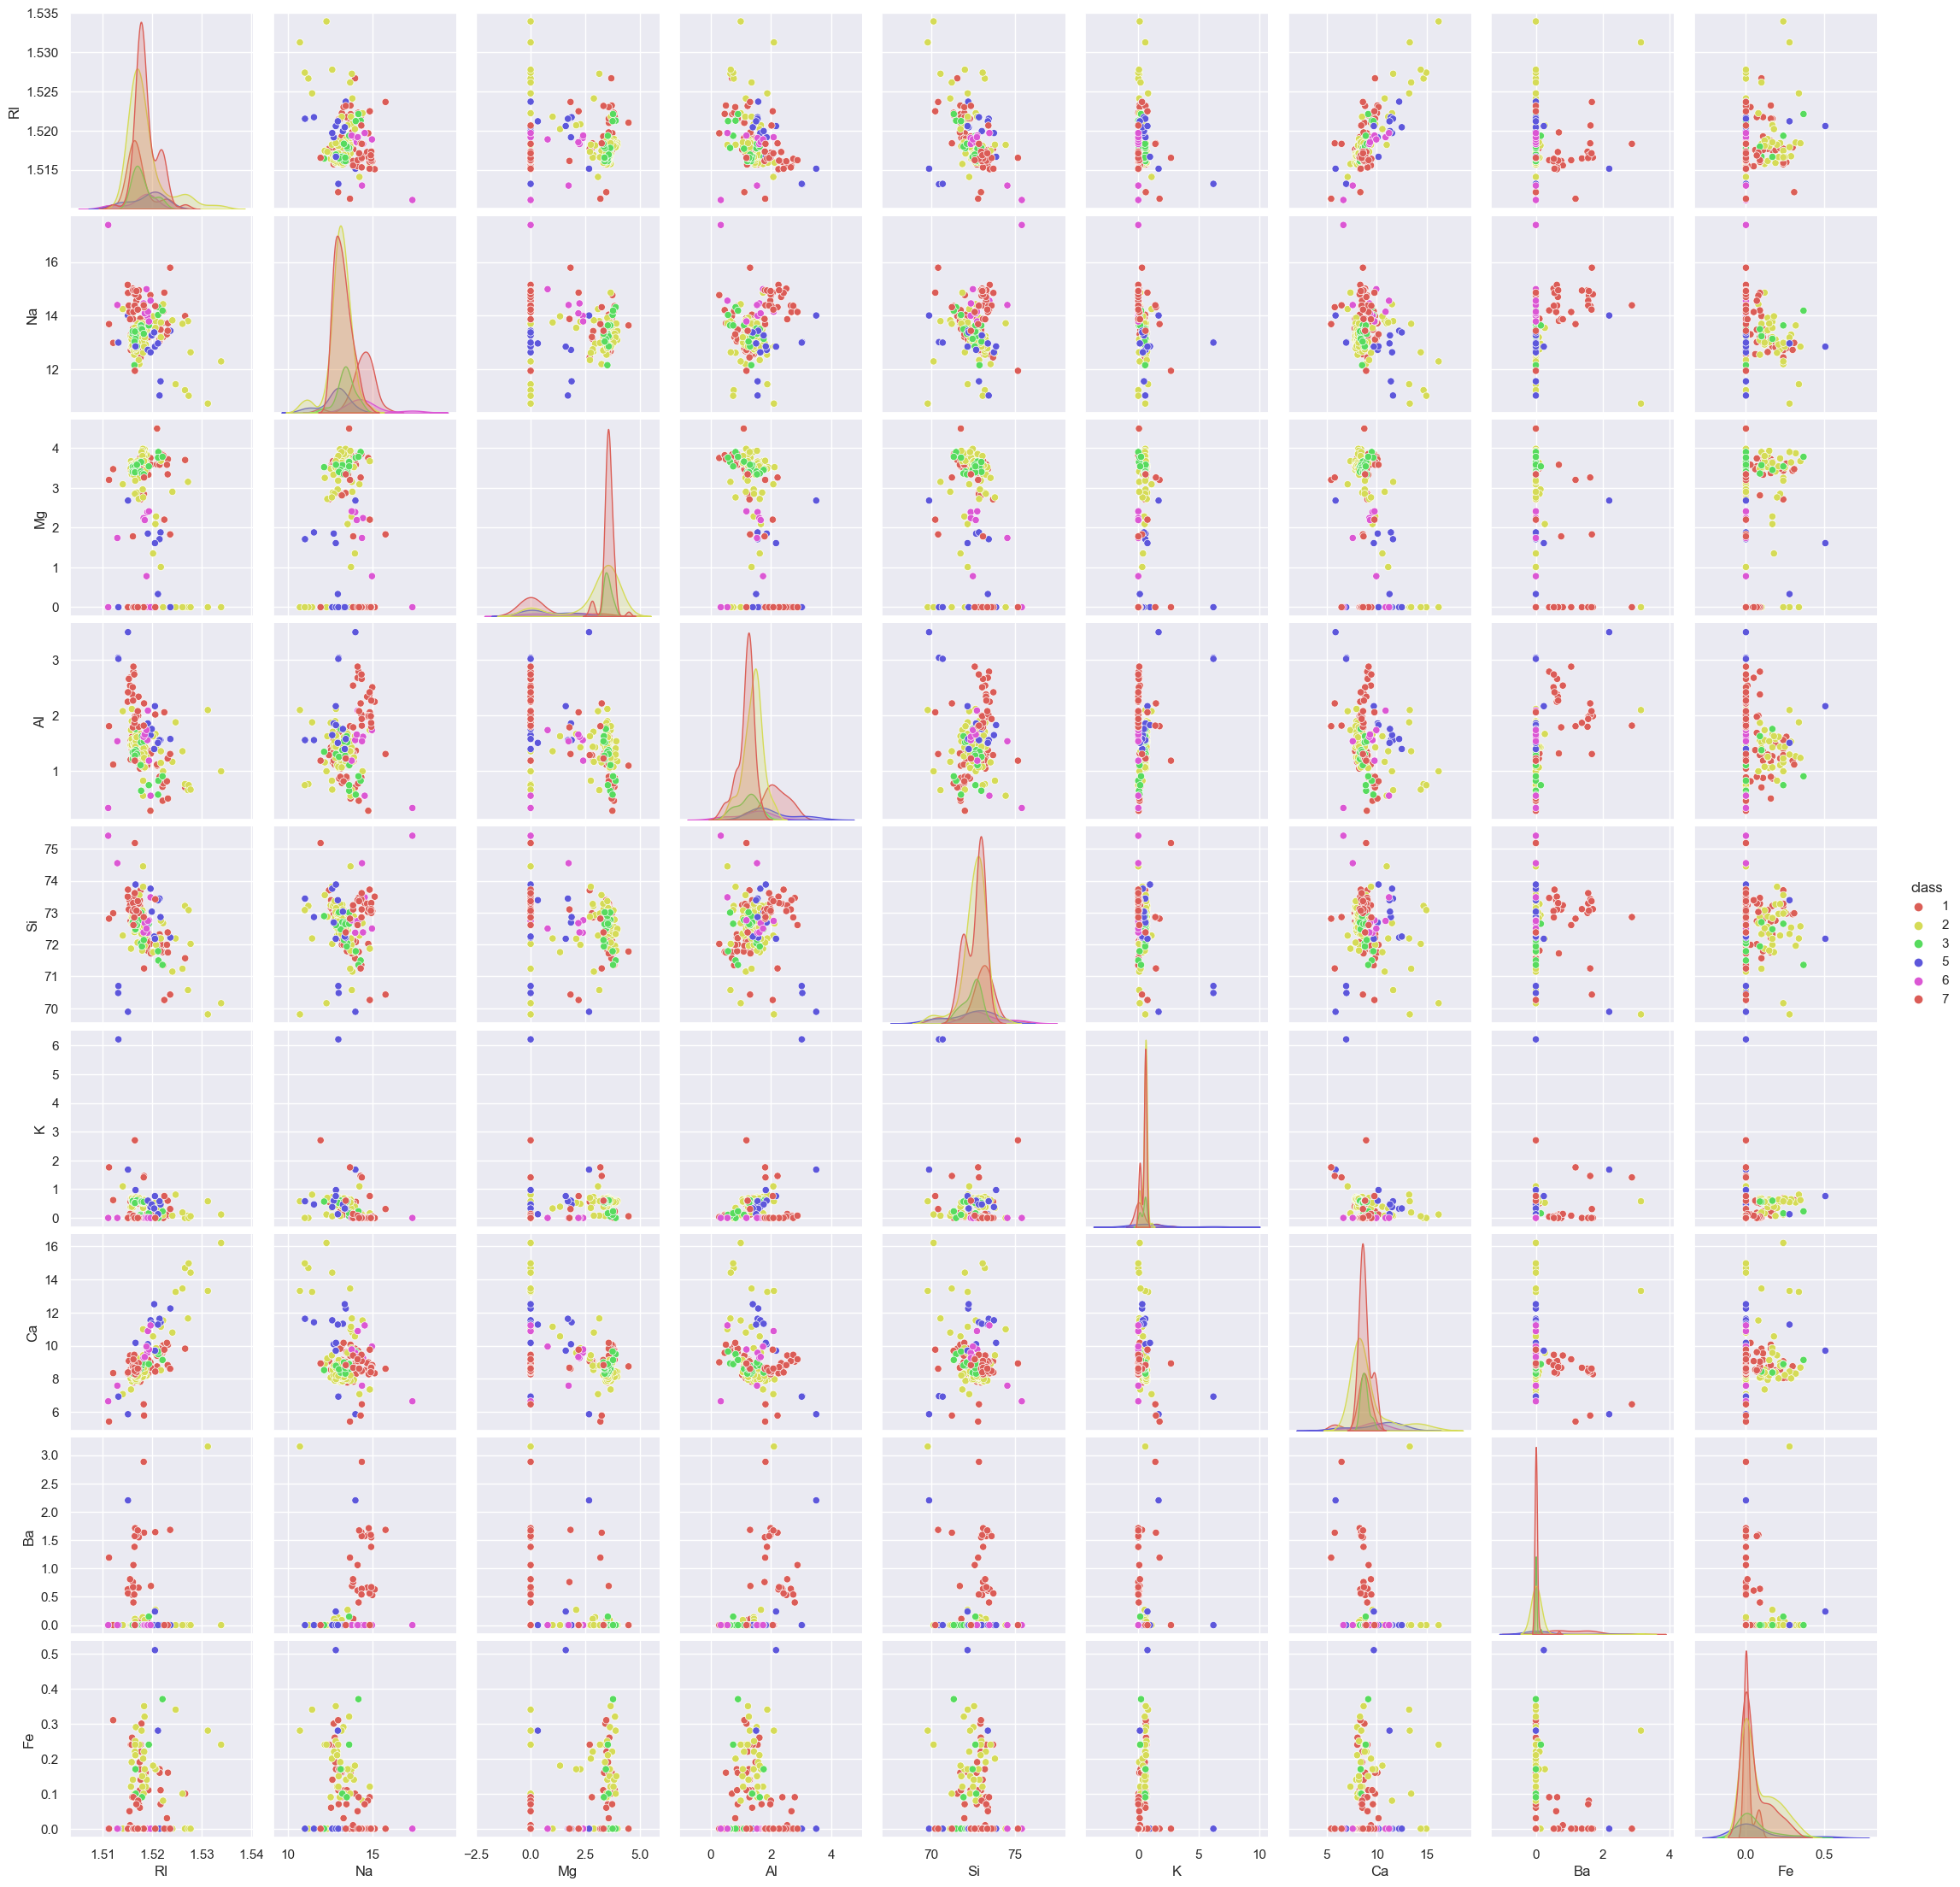

In [139]:
sns.pairplot(dataset.loc[:, dataset.columns != 'id'], hue="class", palette="hls")

<Axes: >

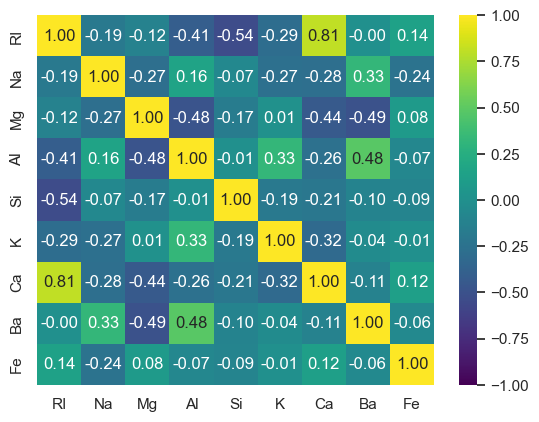

In [140]:
sns.heatmap(dataset[data_cols].corr(), annot=True, fmt=".2f", vmin=-1.0, vmax=1.0, cmap="viridis")

# Preprocessing

In [141]:
fixed_rng = np.random.RandomState(0)
Y = dataset[class_col]
X_full = dataset[data_cols]
X_missing = X_full.mask(fixed_rng.random(X_full.shape) < 0.05)

X_full_train, X_full_test, Y_full_train, Y_full_test = train_test_split(X_full, Y, test_size=0.3, stratify=Y, random_state=fixed_rng)
X_missing_train, X_missing_test, Y_missing_train, Y_missing_test = train_test_split(X_missing, Y, test_size=0.3, stratify=Y, random_state=fixed_rng)

In [142]:
Y_full_test.value_counts().sort_index()

class
1    21
2    23
3     5
5     4
6     3
7     9
Name: count, dtype: int64

In [143]:
Y_missing_test.value_counts().sort_index()

class
1    21
2    23
3     5
5     4
6     3
7     9
Name: count, dtype: int64

In [144]:
imputers = {
    "KNN-1" : KNNImputer(n_neighbors=1),
    "KNN-2" : KNNImputer(n_neighbors=2),
    "MEAN" : SimpleImputer(strategy="mean"),
    "MEDIAN" : SimpleImputer(strategy="median"),
    "MOST-FQ" : SimpleImputer(strategy="most_frequent")
}

transformers = {
    "NONE" : "passthrough",
    "NORMALIZE" : Normalizer(),
    "STANDARIZE" : StandardScaler(),
    "DISCRETIZE-2" : KBinsDiscretizer(n_bins=2, strategy="quantile", encode="onehot-dense"),
    "DISCRETIZE-3" : KBinsDiscretizer(n_bins=3, strategy="quantile", encode="onehot-dense"),
    "DISCRETIZE-5" : KBinsDiscretizer(n_bins=5, strategy="quantile", encode="onehot-dense"),
    "SELECTION-2" : SelectKBest(k=2),
    "SELECTION-3" : SelectKBest(k=3),
    "SELECTION-5" : SelectKBest(k=5),
    "PCA" : PCA(random_state=fixed_rng)
}

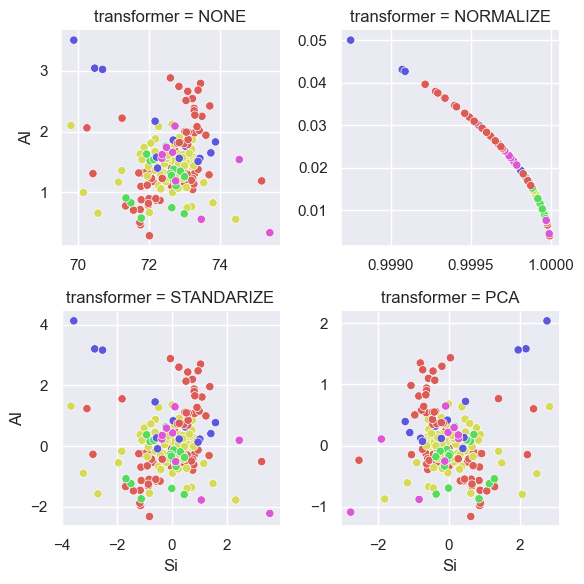

In [145]:
sns.FacetGrid(
    pd.concat(
        pd.DataFrame(
            make_pipeline(transformers[n])
                .fit_transform(dataset[["Si", "Al"]].to_numpy(), dataset[class_col]),
            columns=["Si", "Al"]
        ).assign(**{"transformer": n, "class": dataset[class_col]})
        for n in ["NONE", "NORMALIZE", "STANDARIZE", "PCA"]
    ), col="transformer", col_wrap=2, sharex=False, sharey=False
).map_dataframe(sns.scatterplot, x="Si", y="Al", hue="class", palette="hls")

# Classification

In [146]:
classifiers = {
    "NAIVE-1e-3": GaussianNB(var_smoothing=1e-3),
    "NAIVE-1e-5": GaussianNB(var_smoothing=1e-5),
    "NAIVE-1e-8": GaussianNB(var_smoothing=1e-8),
    "DECISION-TREE-3": DecisionTreeClassifier(max_depth=3, criterion="entropy", random_state=fixed_rng),
    "DECISION-TREE-5": DecisionTreeClassifier(max_depth=5, criterion="entropy", random_state=fixed_rng),
    "DECISION-TREE-8": DecisionTreeClassifier(max_depth=8, criterion="entropy", random_state=fixed_rng),
    "SVC": LinearSVC(random_state=fixed_rng),
    "RANDOM-FOREST": RandomForestClassifier(random_state=fixed_rng)
}

In [147]:
search_pipeline_missing = Pipeline([
    ("imputer", "passthrough"),
    ("transformer", "passthrough"),
    ("classifier", next(iter(classifiers.values())))
])

search_pipeline_full = Pipeline([
    ("transformer", "passthrough"),
    ("classifier", next(iter(classifiers.values())))
])

In [148]:
grid_search_missing = GridSearchCV(search_pipeline_missing, {
    "imputer": list(imputers.values()),
    "transformer": list(transformers.values()),
    "classifier": list(classifiers.values())
}, n_jobs=-1)

grid_search_missing.fit(X_missing_train, Y_missing_train)

print(grid_search_missing.best_score_)
best_pipeline = grid_search_missing.best_estimator_
best_pipeline

0.7588505747126437


Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('transformer', 'passthrough'),
                ('classifier',
                 RandomForestClassifier(random_state=RandomState(MT19937) at 0x27304C43440))])

In [149]:
grid_search_full = GridSearchCV(search_pipeline_full, {
    "transformer": list(transformers.values()),
    "classifier": list(classifiers.values())
}, n_jobs=-1)

grid_search_full.fit(X_full_train, Y_full_train)

print(grid_search_full.best_score_)
best_pipeline = grid_search_full.best_estimator_
best_pipeline

0.7857471264367817


Pipeline(steps=[('transformer', 'passthrough'),
                ('classifier',
                 RandomForestClassifier(random_state=RandomState(MT19937) at 0x272EA8E0140))])

# Results

In [150]:
def lookup(what, where):
    match where:
        case "imputer":
            d = imputers
        case "transformer":
            d = transformers
        case "classifier":
            d = classifiers
    return next(k for k in d if d[k] == what)

polska_gurom = {"classifier": "Klasyfikator", "transformer": "Przetwarzanie danych", "imputer": "Uzupełnianie danych"}

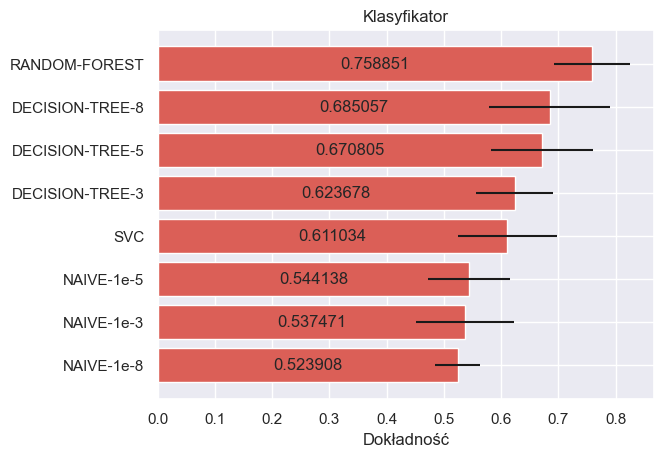

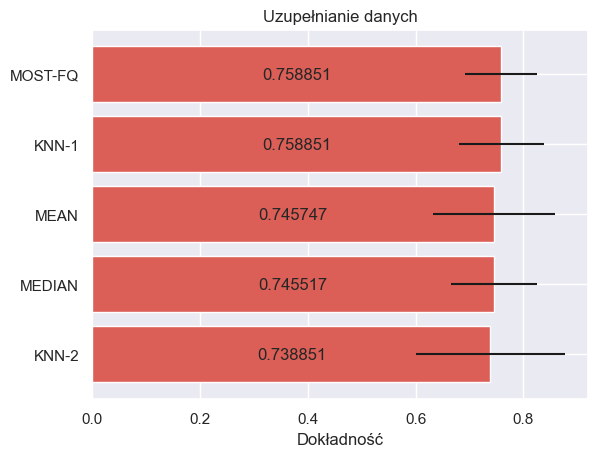

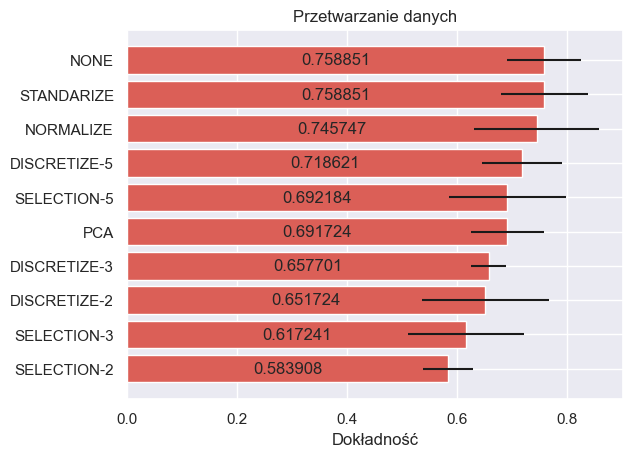

In [158]:

res = grid_search_missing.cv_results_
for i, p in enumerate(grid_search_missing.best_params_.keys()):
    x, y, std = zip(*sorted([
        max([
            (lookup(param, p), entry[1], entry[2])
            for entry in zip(res["params"], res["mean_test_score"], res["std_test_score"])
            if entry[0][p] == param
        ], key=lambda x: x[1])
        for param in grid_search_missing.param_grid[p]
    ], key=lambda x: x[1]))

    ax = plt.axes()
    bar_val = ax.barh(x, y, xerr=std)
    ax.bar_label(bar_val, label_type='center')
    ax.set_title(polska_gurom[p])
    ax.set_xlabel("Dokładność")
    plt.show()

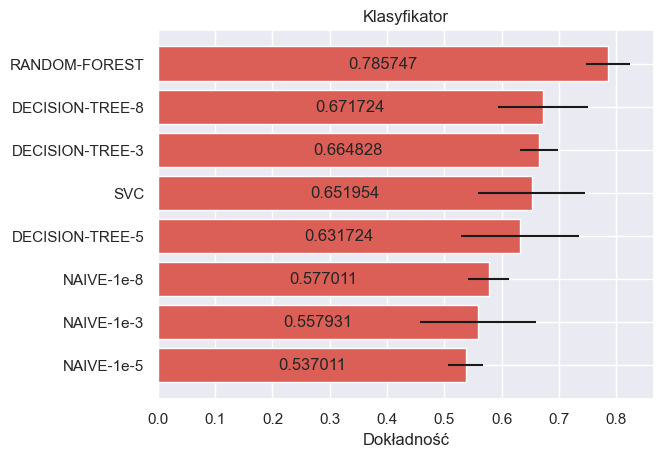

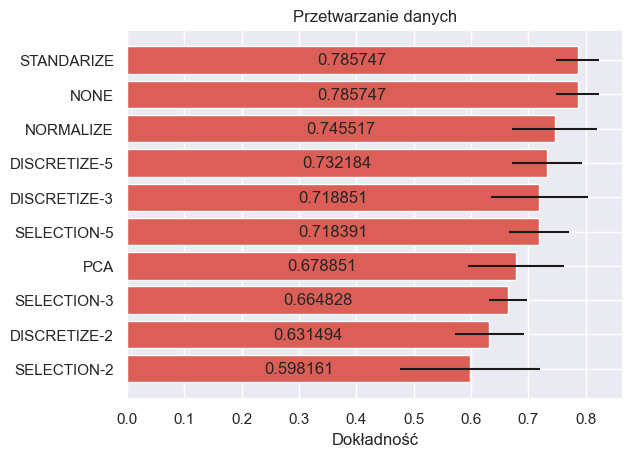

In [157]:

res = grid_search_full.cv_results_
for i, p in enumerate(grid_search_full.best_params_.keys()):
    x, y, std = zip(*sorted([
        max([
            (lookup(param, p), entry[1], entry[2])
            for entry in zip(res["params"], res["mean_test_score"], res["std_test_score"])
            if entry[0][p] == param
        ], key=lambda x: x[1])
        for param in grid_search_full.param_grid[p]
    ], key=lambda x: x[1]))

    ax = plt.axes()
    bar_val = ax.barh(x, y, xerr=std)
    ax.bar_label(bar_val, label_type='center')
    ax.set_title(polska_gurom[p])
    ax.set_xlabel("Dokładność")
    plt.show()

In [167]:
forest_grid = GridSearchCV(
    make_pipeline(
        "passthrough",
        RandomForestClassifier(random_state=fixed_rng)
    ),
    {
        "randomforestclassifier__n_estimators": np.arange(1, 150, 5)
    },
    n_jobs=-1
)

forest_grid.fit(X_full_train, Y_full_train)

GridSearchCV(estimator=Pipeline(steps=[('passthrough', 'passthrough'),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=RandomState(MT19937) at 0x27304C43840))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__n_estimators': array([  1,   6,  11,  16,  21,  26,  31,  36,  41,  46,  51,  56,  61,
        66,  71,  76,  81,  86,  91,  96, 101, 106, 111, 116, 121, 126,
       131, 136, 141, 146])})

[Text(0.5, 0, 'Liczba estymatorów'), Text(0, 0.5, 'Dokładność')]

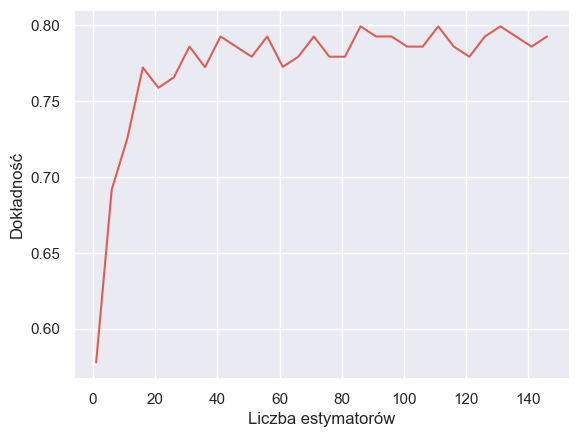

In [169]:
res = sns.lineplot(data=pd.DataFrame({
    "n_estimators": forest_grid.cv_results_["param_randomforestclassifier__n_estimators"],
    "score": forest_grid.cv_results_["mean_test_score"]
}), x="n_estimators", y="score", errorbar="se", )

res.set(xlabel="Liczba estymatorów", ylabel="Dokładność")

In [176]:
grid = GridSearchCV(
    make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        "passthrough",
        RandomForestClassifier(random_state=fixed_rng)
    ),
    {},
    n_jobs=-1
)

grid.fit(X_full_train, Y_full_train)
estimator = grid.best_estimator_

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('passthrough', 'passthrough'),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=RandomState(MT19937) at 0x2730DAE0240))])

In [261]:
estimator.fit(X_full_train, Y_full_train)
predictions = estimator.predict(X_full_test)
print(accuracy_score(Y_full_test, predictions))
print(classification_report(Y_full_test, predictions))

0.8
              precision    recall  f1-score   support

           1       0.75      0.86      0.80        21
           2       0.80      0.87      0.83        23
           3       0.50      0.20      0.29         5
           5       1.00      0.50      0.67         4
           6       1.00      0.67      0.80         3
           7       0.90      1.00      0.95         9

    accuracy                           0.80        65
   macro avg       0.83      0.68      0.72        65
weighted avg       0.80      0.80      0.78        65



In [249]:
estimator.fit(X_missing_train, Y_missing_train)
predictions = estimator.predict(X_missing_test)
print(accuracy_score(Y_missing_test, predictions))
print(classification_report(Y_missing_test, predictions))

0.7846153846153846
              precision    recall  f1-score   support

           1       0.72      0.86      0.78        21
           2       0.78      0.78      0.78        23
           3       0.50      0.20      0.29         5
           5       1.00      0.75      0.86         4
           6       0.75      1.00      0.86         3
           7       1.00      0.89      0.94         9

    accuracy                           0.78        65
   macro avg       0.79      0.75      0.75        65
weighted avg       0.78      0.78      0.77        65

